# MeV RH Neutrino Dark Matter

In [1]:
from scipy.integrate import quad
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict


In [2]:
from hazma.gamma_ray_parameters import egret_diffuse, fermi_diffuse, comptel_diffuse, gecco_bg_model
from hazma.gamma_ray_parameters import A_eff_comptel, A_eff_egret, A_eff_fermi, energy_res_comptel, BackgroundModel
from hazma.gamma_ray_parameters import (
    gc_bg_model, default_bg_model
)
from hazma.gamma_ray_parameters import (
    gc_targets_optimistic, A_eff_e_astrogam, energy_res_e_astrogam, T_obs_e_astrogam, TargetParams, energy_res_adept, energy_res_amego, energy_res_mast, energy_res_pangu, energy_res_fermi, energy_res_egret
)
from hazma.gamma_ray_parameters import (
    A_eff_gecco, energy_res_gecco, energy_res_gecco_large, gc_targets, fornax_targets, m31_targets, draco_targets, A_eff_adept, A_eff_amego, A_eff_mast, A_eff_pangu
)

In [7]:
from hazma.rh_neutrino import RHNeutrino

In [8]:
# This is approximately the same as `gc_bg_model`, but does not constrain
# the input energies.
gc_bg_model_approx = BackgroundModel(
    [0, 1e5], lambda e: 7 * default_bg_model.dPhi_dEdOmega(e)
)

In [15]:
# Other constants
T_obs_nt = 1e6  # s. From Alex.
v_mw = 1e-3
x_kd = 1e-6  # should compute this for actual models...

# Best selection of targets
nt_targets_ann = {
    "gc_ein_1_arcmin_cone_optimistic": (
        gc_targets_optimistic["ein"]["1 arcmin cone"], gc_bg_model_approx
    ),
    "gc_nfw_1_arcmin_cone": (gc_targets["nfw"]["1 arcmin cone"], gc_bg_model_approx),
    "m31_nfw_1_arcmin_cone": (m31_targets["nfw"]["1 arcmin cone"], gecco_bg_model),
    "draco_nfw_1_arcmin_cone": (
        draco_targets["nfw"]["1 arcmin cone"], gecco_bg_model
    )
}
nt_targets_dec = {
    "gc_ein_5_deg_optimistic": (
        gc_targets_optimistic["ein"]["5 deg cone"], gc_bg_model_approx
    ),
    "gc_nfw_5_deg": (gc_targets["nfw"]["5 deg cone"], gc_bg_model_approx),
    "m31_nfw_5_deg": (m31_targets["nfw"]["5 deg cone"], gecco_bg_model),
    "draco_nfw_5_deg": (
        draco_targets["nfw"]["5 deg cone"], gecco_bg_model
    )
}

def get_constraints(model, mxs):
    constraints = defaultdict(lambda: np.zeros(len(mxs)))

    for i, mx in enumerate(mxs):
        model.mx = mx

        # Constraints from existing data
        constraints["comptel"][i] = model.binned_limit(comptel_diffuse)
        constraints["egret"][i] = model.binned_limit(egret_diffuse)
        constraints["fermi"][i] = model.binned_limit(fermi_diffuse)
        
        e_window_0=None

        # Projections
        nt_targets = nt_targets_ann if model.kind == "ann" else nt_targets_dec
        for key, (target, bg_model) in nt_targets.items():
            constraints["adept_" + key][i] = model.unbinned_limit(
                A_eff_adept, energy_res_adept, T_obs_nt, target, bg_model,
                e_window_0=e_window_0, # debug_msgs=True
            )
            constraints["amego_" + key][i] = model.unbinned_limit(
                A_eff_amego, energy_res_amego, T_obs_nt, target, bg_model,
                e_window_0=e_window_0, # debug_msgs=True
            )
            constraints["e-astrogam_" + key][i] = model.unbinned_limit(
                A_eff_e_astrogam, energy_res_e_astrogam, T_obs_nt, target, bg_model,
                e_window_0=e_window_0, # debug_msgs=True
            )
            constraints["gecco_" + key][i] = model.unbinned_limit(
                A_eff_gecco, energy_res_gecco, T_obs_nt, target, bg_model,
                e_window_0=e_window_0, # debug_msgs=True
            )
            constraints["mast_" + key][i] = model.unbinned_limit(
                A_eff_mast, energy_res_mast, T_obs_nt, target, bg_model,
                e_window_0=e_window_0, # debug_msgs=True
            )
            constraints["pangu_" + key][i] = model.unbinned_limit(
                A_eff_pangu, energy_res_pangu, T_obs_nt, target, bg_model,
                e_window_0=e_window_0, # debug_msgs=True
            )

        # CMB (s-wave)
        # TODO: not sure how this works for decaying DM...
        if model.kind == "ann":
            constraints["cmb"][i] = model.cmb_limit(x_kd=x_kd)

    return dict(constraints)

def get_constraint_label(key):
    label = key.replace("amego_", "AMEGO ")
    label = label.replace("adept_", "AdEPT ")
    label = label.replace("comptel", "COMPTEL ")
    label = label.replace("e-astrogam_", "e-ASTROGAM ")
    label = label.replace("egret", "EGRET ")
    label = label.replace("fermi", "Fermi ")
    label = label.replace("gecco_", "GECCO ")
    label = label.replace("mast_", "MAST ")
    label = label.replace("pangu_", "PANGU ")
    
    label = label.replace("gc_nfw_1_arcmin_cone", "(GC $1'$, NFW)")
    label = label.replace("gc_nfw_5_deg", "(GC $5^\circ$, NFW)")
    label = label.replace("gc_ein_1_arcmin_cone_optimistic", "(GC $1'$, Einasto)")
    label = label.replace("gc_ein_5_deg_optimistic", "(GC $5^\circ$, Einasto)")
    label = label.replace("m31_nfw_1_arcmin_cone", "(M31 $1'$)")
    label = label.replace("m31_nfw_5_deg", "(M31 $5^\circ$)")
    label = label.replace("draco_nfw_1_arcmin_cone", "(Draco $1'$)")
    label = label.replace("draco_nfw_5_deg", "(Draco $5^\circ$)")
    
    return label

def get_fs_label(fs):
    if fs == "e e":
        return r"$e^+ e^-$"
    elif fs == "mu mu":
        return r"$\mu^+ \mu^-$"
    elif fs == "pi pi":
        return r"$\pi^+ \pi^-$"
    elif fs == "pi0 pi0":
        return r"$\pi^0 \pi^0$"
    elif fs == "pi0 g":
        return r"$\pi^0 \gamma$"
    elif fs == "g g":
        return r"$\gamma \gamma$"
    else:
        return fs

def get_formatted_fig(nrows, ncols, figsize, xlim, ylim):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)

    for ax in axes[-1]:
        ax.set_xlabel(r"$m_\chi$ [MeV]")

    for ax in axes[:, 0]:
        ax.set_ylabel(r"$\langle \sigma v \rangle_{\bar{\chi}\chi, 0}$ [cm$^3$/s]")

    for ax in axes.flatten():
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.grid()

    return fig, axes

In [17]:
model = RHNeutrino(500.0, 1e-3, 'e')
mxs = np.logspace(np.log10(140), np.log10(500), 100)
constraints = get_constraints(model, mxs)

/home/logan/.local/lib/python3.8/site-packages/hazma/background_model.py:42: UserWarning: The gamma ray background model is not applicable for energy 101215.995655 MeV.
  warnings.warn(
/home/logan/.local/lib/python3.8/site-packages/hazma/background_model.py:42: UserWarning: The gamma ray background model is not applicable for energy 10017.780306 MeV.
  warnings.warn(
/home/logan/.local/lib/python3.8/site-packages/hazma/background_model.py:42: UserWarning: The gamma ray background model is not applicable for energy 0.154866 MeV.
  warnings.warn(
/home/logan/.local/lib/python3.8/site-packages/hazma/background_model.py:42: UserWarning: The gamma ray background model is not applicable for energy 4001.804926 MeV.
  warnings.warn(
/home/logan/.local/lib/python3.8/site-packages/hazma/decay.py:141: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_charged_pion.Spectrum(photon_energies, pion_energy, mode)
/home/logan/.local/lib/python3.8/site-packages

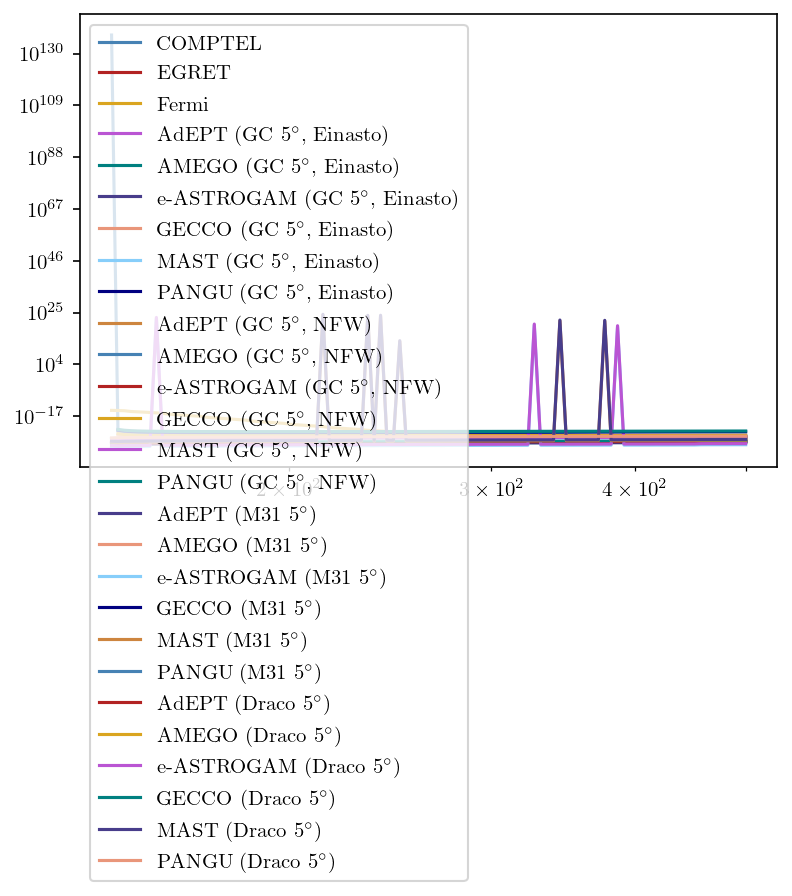

In [18]:
plt.figure(dpi=150)

for key, c in constraints.items():
    plt.plot(mxs, c, label=get_constraint_label(key))

plt.legend()
plt.yscale('log')
plt.xscale('log')

In [19]:
constraints.keys()

dict_keys(['comptel', 'egret', 'fermi', 'adept_gc_ein_5_deg_optimistic', 'amego_gc_ein_5_deg_optimistic', 'e-astrogam_gc_ein_5_deg_optimistic', 'gecco_gc_ein_5_deg_optimistic', 'mast_gc_ein_5_deg_optimistic', 'pangu_gc_ein_5_deg_optimistic', 'adept_gc_nfw_5_deg', 'amego_gc_nfw_5_deg', 'e-astrogam_gc_nfw_5_deg', 'gecco_gc_nfw_5_deg', 'mast_gc_nfw_5_deg', 'pangu_gc_nfw_5_deg', 'adept_m31_nfw_5_deg', 'amego_m31_nfw_5_deg', 'e-astrogam_m31_nfw_5_deg', 'gecco_m31_nfw_5_deg', 'mast_m31_nfw_5_deg', 'pangu_m31_nfw_5_deg', 'adept_draco_nfw_5_deg', 'amego_draco_nfw_5_deg', 'e-astrogam_draco_nfw_5_deg', 'gecco_draco_nfw_5_deg', 'mast_draco_nfw_5_deg', 'pangu_draco_nfw_5_deg'])

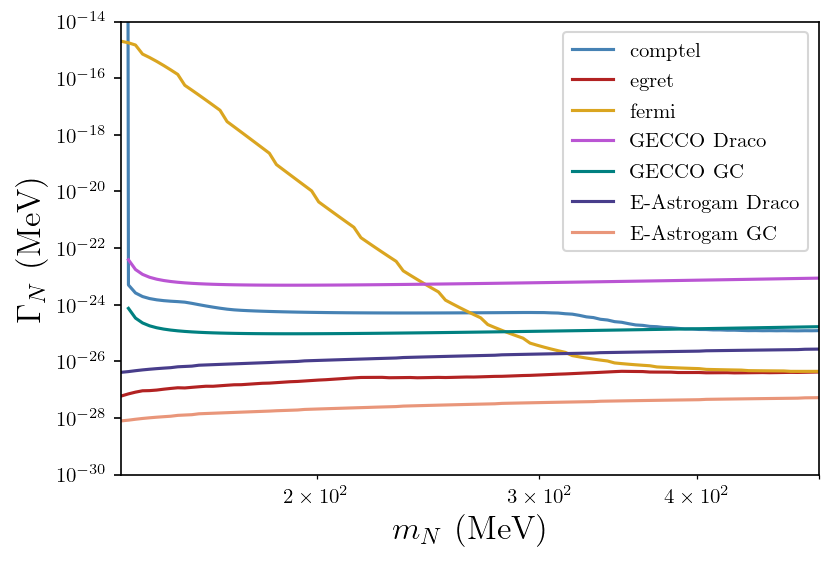

In [48]:
plt.figure(dpi=150)

plt.plot(mxs, constraints['comptel'],label='comptel')
plt.plot(mxs, constraints['egret'],label='egret')
plt.plot(mxs, constraints['fermi'],label='fermi')
plt.plot(mxs, constraints['gecco_draco_nfw_5_deg'],label=r'GECCO Draco')
plt.plot(mxs, constraints['gecco_gc_nfw_5_deg'], label='GECCO GC')
plt.plot(mxs, constraints['e-astrogam_draco_nfw_5_deg'],label=r'E-Astrogam Draco')
plt.plot(mxs, constraints['e-astrogam_gc_nfw_5_deg'], label='E-Astrogam GC')

plt.xlim([np.min(mxs),np.max(mxs)])
plt.ylim([1e-30,1e-14])

plt.xlabel(r'$m_{N} \ (\mathrm{MeV})$', fontsize=16)
plt.ylabel(r'$\Gamma_{N} \ (\mathrm{MeV})$', fontsize=16)

plt.legend(loc=1)
plt.yscale('log')
plt.xscale('log')

plt.savefig('figures/rh_neutrino_id_constraints_electron.pdf')

In [45]:
model = RHNeutrino(500.0, 1e-3, 'mu')
mxs = np.logspace(np.log10(140), np.log10(500), 100)
constraints_mu = get_constraints(model, mxs)

/home/logan/.local/lib/python3.8/site-packages/hazma/background_model.py:42: UserWarning: The gamma ray background model is not applicable for energy 101215.995655 MeV.
  warnings.warn(
/home/logan/.local/lib/python3.8/site-packages/hazma/background_model.py:42: UserWarning: The gamma ray background model is not applicable for energy 10017.780306 MeV.
  warnings.warn(
/home/logan/.local/lib/python3.8/site-packages/hazma/background_model.py:42: UserWarning: The gamma ray background model is not applicable for energy 0.154866 MeV.
  warnings.warn(
/home/logan/.local/lib/python3.8/site-packages/hazma/background_model.py:42: UserWarning: The gamma ray background model is not applicable for energy 4001.804926 MeV.
  warnings.warn(
/home/logan/.local/lib/python3.8/site-packages/hazma/decay.py:53: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_muon.Spectrum(photon_energies, muon_energy)
/home/logan/.local/lib/python3.8/site-packages/hazma/decay.py

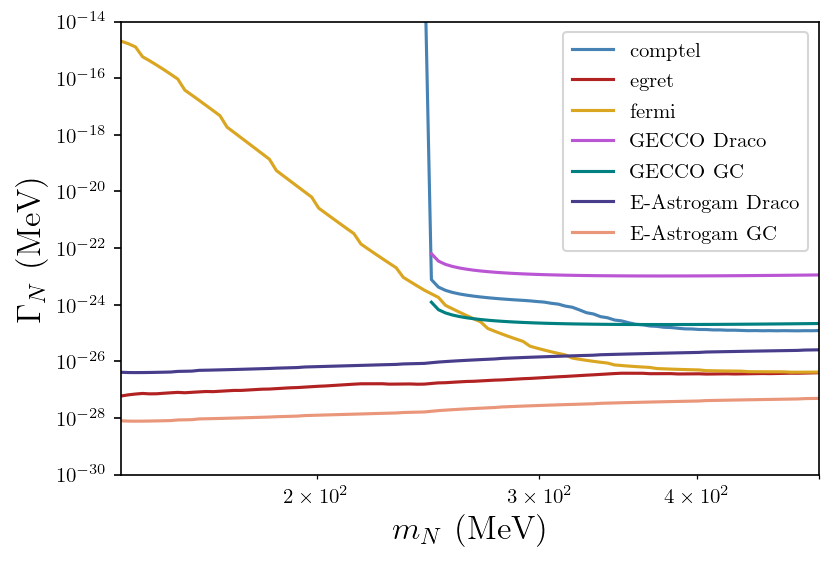

In [47]:
plt.figure(dpi=150)

plt.plot(mxs, constraints_mu['comptel'],label='comptel')
plt.plot(mxs, constraints_mu['egret'],label='egret')
plt.plot(mxs, constraints_mu['fermi'],label='fermi')
plt.plot(mxs, constraints_mu['gecco_draco_nfw_5_deg'],label=r'GECCO Draco')
plt.plot(mxs, constraints_mu['gecco_gc_nfw_5_deg'], label='GECCO GC')
plt.plot(mxs, constraints_mu['e-astrogam_draco_nfw_5_deg'],label=r'E-Astrogam Draco')
plt.plot(mxs, constraints_mu['e-astrogam_gc_nfw_5_deg'], label='E-Astrogam GC')

plt.xlim([np.min(mxs),np.max(mxs)])
plt.ylim([1e-30,1e-14])

plt.xlabel(r'$m_{N} \ (\mathrm{MeV})$', fontsize=16)
plt.ylabel(r'$\Gamma_{N} \ (\mathrm{MeV})$', fontsize=16)

plt.legend(loc=1)
plt.yscale('log')
plt.xscale('log')

plt.savefig('figures/rh_neutrino_id_constraints_muon.pdf')

## Spectra

In [4]:
model=RHNeutrino(500.0, 1e-3, 'e')

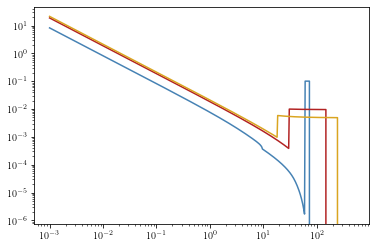

In [6]:
es = np.logspace(-3, np.log10(model.mx), 500)
spec = model.total_spectrum(es)

mxs = [150, 300, 500]

for mx in mxs:
    model.mx = mx
    spec = model.total_spectrum(es)
    plt.plot(es, spec)
plt.yscale('log')
plt.xscale('log')

In [20]:
model.mx

500.0

In [ ]:
model.constrain_gamma()